# Correlation Between Samples

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [2]:
from common.data import get_data
from common.paths import HEALTHY, WISC

X, Y, demographics, population = get_data(wisc_level=5, label_path=WISC)
ages = demographics['Age']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (380, 34716) | Y: 6 | Age: (380,) | Population: adhd


In [3]:
selected_target = "WISC_FSIQ"
y = Y[selected_target]

print(f'y: {y.shape}')

y: (380,)


In [9]:
from common.binning import bin_by_age, ONLY_BIN_LABELS

bins = bin_by_age(X, y, ages)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

Bin 1: (114, 34716) | Bin 2: (152, 34716) | Bin 3: (114, 34716)


### Generate fake data

In [16]:
from common.data import generate_fake_data

X, y = generate_fake_data(X, y)

print(f'X: {X.shape}')

X: (106, 34716)


## Correlate

In [5]:
from scipy import stats
from sklearn.model_selection import LeaveOneOut

### Correlate every sample (all combinations)

In [9]:
correlations = []

for index, curr_subject in enumerate(X):
    for next_subject in X[index + 1:len(X) + 1]:
        correlations.append(stats.pearsonr(curr_subject, next_subject)[0])

print(f'Num correlations: {len(correlations)}')

Num correlations: 5565


Text(0.5, 1.0, 'Population=healthy, n=106, num_correlations=5565')

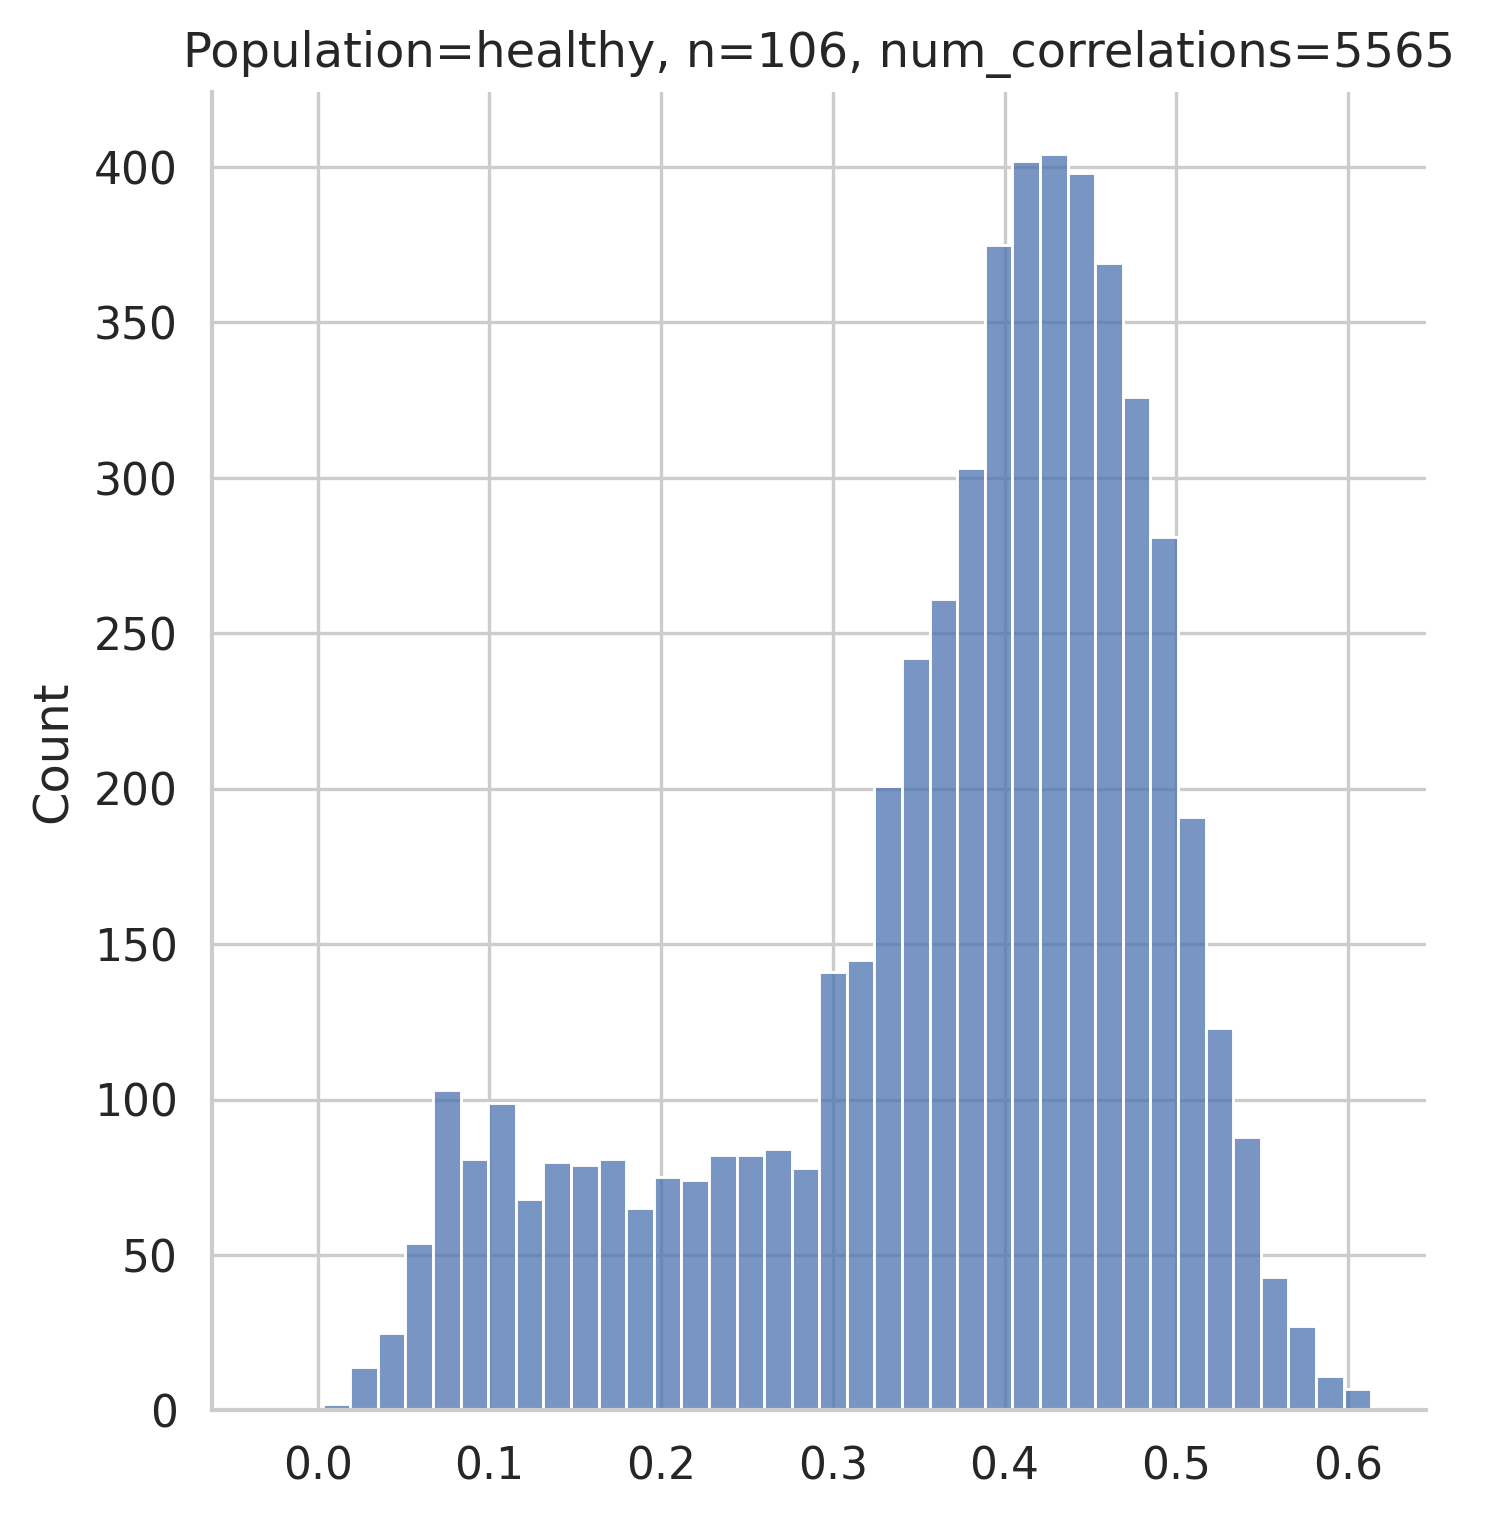

In [10]:
g = sns.displot(correlations)
g.ax.set_title(f'method=all, population={population}, n={len(X)}, num_correlations={len(correlations)}')

### Correlate every sample (leave-one-out)

In [12]:
X_loo = bin_3[0]
population = ONLY_BIN_LABELS[2]

correlations = []
bad_subjects = []
loo = LeaveOneOut()

for rest_subjects, curr_subject in loo.split(X_loo):
    X_curr, X_rest = X[curr_subject][0], X[rest_subjects]
    X_rest_mean = np.mean(X_rest, axis=0)
    r, p = stats.pearsonr(X_curr, X_rest_mean)
    correlations.append(r)
#     if r < 0.5:
#         bad_subjects.append(curr_subject[0])

print(f'Num correlations: {len(correlations)}')
# print(len(bad_subjects), bad_subjects)

Num correlations: 114


Text(0.5, 1.0, 'method=loo, population=Bin 3, n=380, num_correlations=114')

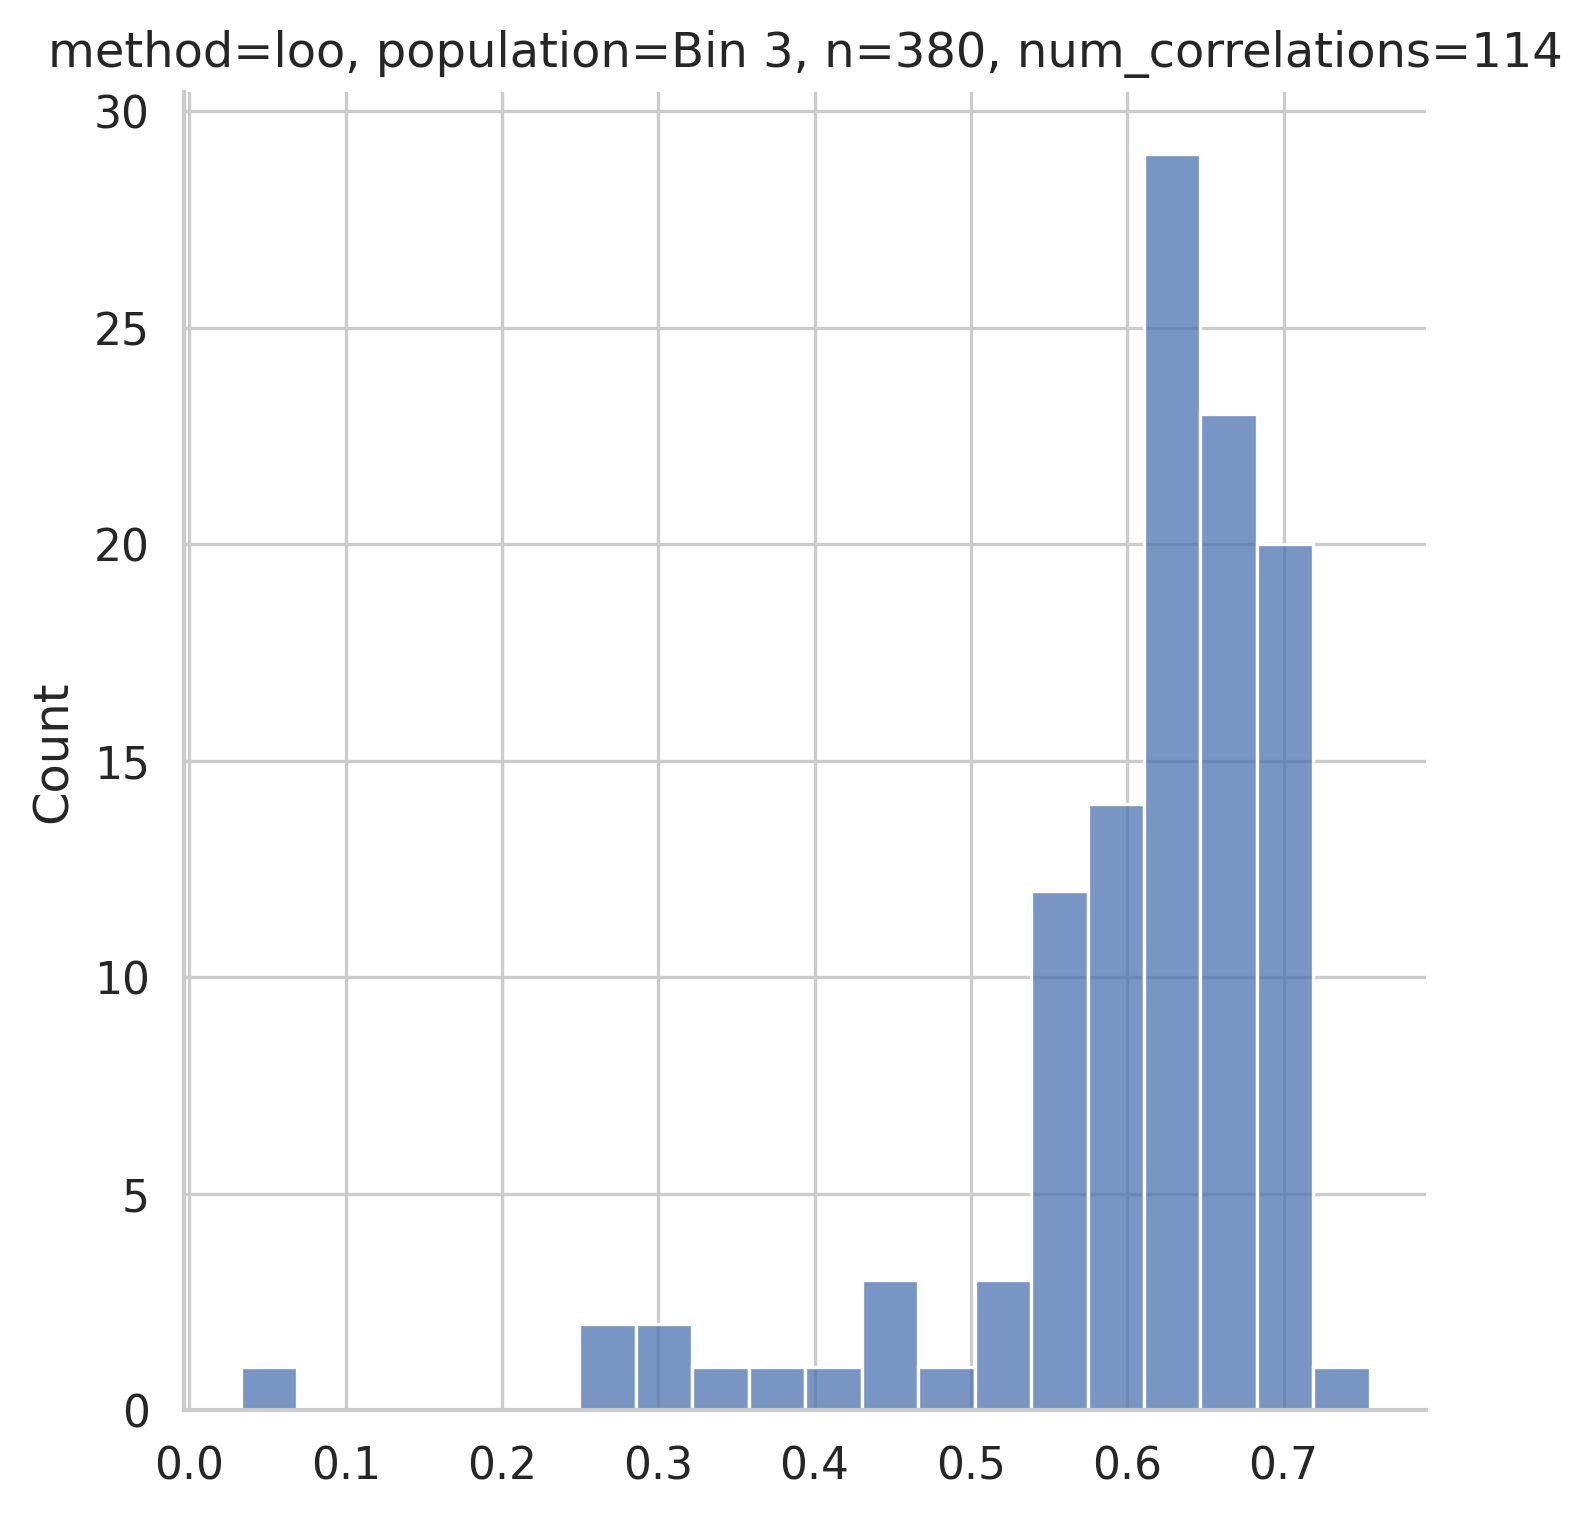

In [13]:
g = sns.displot(correlations)
g.ax.set_title(f'method=loo, population={population}, n={len(X)}, num_correlations={len(correlations)}')